Code description:
A simple learning program for recognizing hand-writing digits based on the pytorch package and the MNIST dataset, including the following steps:
1. Download MNIST.
2. Visualize examples of MNIST.
3. Construct a CNN and train & test it.
4. Plot a figure of training error, test error, accuracy vs. learning process.
5. Visualize examples of the predictions.

In [1]:
'''
Creation Date: 2021-10-02 14:00
Description: a simple code for learning the MNIST dataset using the pytorch package.
Author: Hao-Kai Zhang <zhk20@mails.tsinghua.edu.cn>
'''

import torch
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt

In [2]:
'''Load MNIST'''

# define the example batch sizes for training and test
batch_size_train = 50
batch_size_test = 100

# load training data
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data/', 
                               train=True, 
                               download=False, # True if not downloaded yet
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,)) 
                                   # mean and standard deviation of MNIST
                               ])),
    batch_size=batch_size_train, shuffle=True)

# load test data
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data/', 
                               train=False, 
                               download=False, # True if not downloaded yet
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,)) 
                                   # mean and standard deviation of MNIST
                               ])),
    batch_size=batch_size_test, shuffle=True)

torch.Size([100, 1, 28, 28])


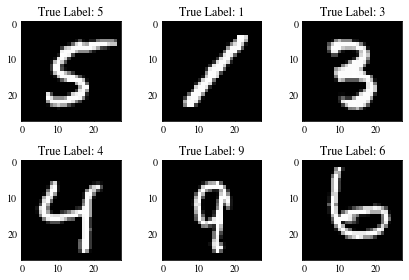

In [3]:
'''Visualize examples of MNIST'''

# set font style
font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

# set ticks in
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# pick some examples by an iterator
examples = enumerate(test_loader)
batch_idx, (example_data, example_labels) = next(examples)
print(example_data.shape)

# plot some hand-writing digits with their labels
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title("True Label: {}".format(example_labels[i]))
plt.show()

Figure 1: Some test examples with their true labels.

In [4]:
'''Construct a CNN and train & test it'''

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# define hyperparameters
NUM_EPOCHS = 3
LR = 0.025
MOMENTUM = 0.5
PRINT_STEP = 50
SEED = 0

# create lists to record the losses
train_losses = []
train_steps = []
test_losses = []
test_accuracies = []
test_steps = [i*len(train_loader.dataset) for i in range(NUM_EPOCHS + 1)]

# define a neural network
class MNIST_Net(nn.Module):
    # layers: input-C0(pool)-C1(pool,dropout)-F0(dropout)-F1-output
    # activation: ReLU
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # two convolutional layers
        self.conv_layer_0 = nn.Conv2d(1, 12, kernel_size=5) # in_channels, out_channels
        self.conv_layer_1 = nn.Conv2d(12, 24, kernel_size=5)
        self.conv_layer_1_drop = nn.Dropout2d()
        # two full connected layers
        self.full_layer_0 = nn.Linear(384, 50) # in_features, out_features, bias=True
        self.full_layer_1 = nn.Linear(50, 10)
        
    # define the forward propagation
    def forward(self, x):
        # add two convolutional layers with pooling operations
        # x.shape = (50,1,28,28)
        x = self.conv_layer_0(x)
        # x.shape = (50,12,24,24) due to kernel_size=5, 28-(5-1)=24
        x = F.relu(F.max_pool2d(x, kernel_size=2))
        # x.shape = (50,12,12,12)
        x = self.conv_layer_1_drop(self.conv_layer_1(x))
        # x.shape = (50,24,8,8)
        x = F.relu(F.max_pool2d(x, kernel_size=2))
        # x.shape = (50,24,4,4)
        # reshape tensor
        x = x.view(-1, 384)
        # x.shape = (50, 384) due to 24*4*4=384
        # add two full connected layers
        x = F.relu(self.full_layer_0(x))
        x = F.dropout(x, training=self.training)
        x = self.full_layer_1(x)
        # transfer outputs to (log) probabilities by (log) softmax
        return F.log_softmax(x, dim=1)

# instantiate a CNN
my_cnn = MNIST_Net()
# use SGD as optimizer
optimizer = optim.SGD(
    my_cnn.parameters(), 
    lr=LR,
    momentum=MOMENTUM,
)
# define the random seed
torch.manual_seed(SEED)

# define the training process for a single epoch
def my_train(epoch):
    # use train() instead of eval() to activate dropout()
    my_cnn.train()
    # for each batch of examples
    for batch_idx, (data, label) in enumerate(train_loader):
        # clear the gradients
        optimizer.zero_grad()
        # compute the ouput (forward propagation)
        output = my_cnn(data)
        # calculate the loss function: negative log likelihood loss
        # CrossEntropyLoss() = nll_loss(log_softmax())
        loss = F.nll_loss(output, label)
        # compute the gradients (backward propagation)
        loss.backward()
        # update the variational model parameters
        optimizer.step()
        # print the variation process
        if batch_idx % PRINT_STEP == 0:
            print('Epoch: {} \tProcess: {}/{} ({:.0f}%) \tLoss: {:.6f}'.format(
                epoch, # epoch index
                batch_idx * len(data), # the amount of data used
                len(train_loader.dataset), # the amount of all data
                batch_idx / len(train_loader) * 100., # ratio used/all
                loss.item(), # use item() to obtain the single value from the tensor type
            ))
            # record the loss/training error
            train_losses.append(loss.item())
            # record the corresponding learning step
            train_steps.append(
                epoch * len(train_loader.dataset) + batch_idx * batch_size_train
            )

# define the test process after a single epoch
def my_test():
    # use eval() instead of train() to inactivate dropout()
    my_cnn.eval()
    # record test error and accuracy
    test_loss = 0
    num_correct = 0
    # use no_grad() to stop computational graph construction & automatic differentiation
    with torch.no_grad():
        # for each batch in test_loader
        for data, label in test_loader:
            # compute the output (forward propagation)
            output = my_cnn(data)
            # add up the loss / test error
            test_loss += F.nll_loss(output, label, reduction='sum').item()
            # take the label / index with the maximum weight as our prediction
            prediction = output.data.max(dim=1)[1] # [0] value  [1] index
            # plus one if the prediction is correct
            num_correct += prediction.eq(label.data.view_as(prediction)).sum()
        # test loss average over examples
        test_loss /= len(test_loader.dataset)
        # record test loss
        test_losses.append(test_loss)
        # calculate accuracy
        test_accuracy = num_correct / len(test_loader.dataset) * 100.
        # record accuracy
        test_accuracies.append(test_accuracy)
        # print the test results
        print('\nTest set: All \tLoss: {:.4f} \tAccuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, 
            num_correct, 
            len(test_loader.dataset),
            test_accuracy,
        ))

# start to train & test for each epoch
my_test()
for epoch in range(0, NUM_EPOCHS):
    my_train(epoch)
    my_test()


Test set: All 	Loss: 2.3148 	Accuracy: 592/10000 (6%)

Epoch: 0 	Process: 0/60000 (0%) 	Loss: 2.338561
Epoch: 0 	Process: 2500/60000 (4%) 	Loss: 2.018514
Epoch: 0 	Process: 5000/60000 (8%) 	Loss: 1.122880
Epoch: 0 	Process: 7500/60000 (12%) 	Loss: 0.882906
Epoch: 0 	Process: 10000/60000 (17%) 	Loss: 0.637423
Epoch: 0 	Process: 12500/60000 (21%) 	Loss: 0.547195
Epoch: 0 	Process: 15000/60000 (25%) 	Loss: 0.571824
Epoch: 0 	Process: 17500/60000 (29%) 	Loss: 0.386523
Epoch: 0 	Process: 20000/60000 (33%) 	Loss: 0.670132
Epoch: 0 	Process: 22500/60000 (38%) 	Loss: 0.495457
Epoch: 0 	Process: 25000/60000 (42%) 	Loss: 0.185317
Epoch: 0 	Process: 27500/60000 (46%) 	Loss: 0.397817
Epoch: 0 	Process: 30000/60000 (50%) 	Loss: 0.443912
Epoch: 0 	Process: 32500/60000 (54%) 	Loss: 0.229709
Epoch: 0 	Process: 35000/60000 (58%) 	Loss: 1.107625
Epoch: 0 	Process: 37500/60000 (62%) 	Loss: 0.482555
Epoch: 0 	Process: 40000/60000 (67%) 	Loss: 0.496523
Epoch: 0 	Process: 42500/60000 (71%) 	Loss: 0.304088


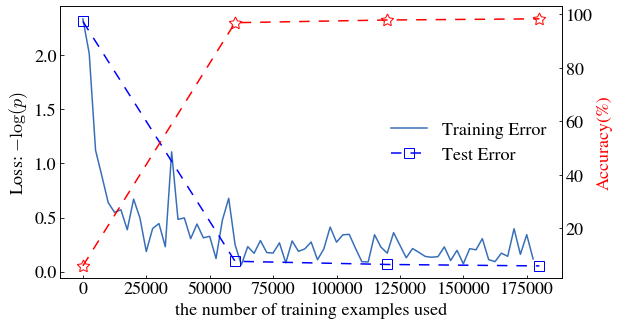

In [5]:
'''Plot a figure of training error, test error, accuracy vs. learning process'''

# create a new figure
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
# plot training errors
ax.plot(
    train_steps, train_losses, 
    color=(55 / 255, 110 / 255, 184 / 255),
)
# plot test errors
ax.plot(
    test_steps, test_losses,
    marker='s',
    linestyle=(0, (7, 6)),
    markersize=10,
    color='blue',
    markerfacecolor='none',
)
# create a twin axis
ax_twin = ax.twinx()
# plot accuracies
ax_twin.plot(
    test_steps, test_accuracies,
    marker=(5, 1),
    linestyle=(0, (7, 6)),
    markersize=13,
    color='red',
    markerfacecolor='none',
)
# set legends
font_xy = {'family': font_family, 'size': 18}
ax.legend(
    ['Training Error', 'Test Error'], 
    loc='right',
    prop=font_xy,
    frameon=False,
)
# set labels
font_size_label = 18
ax.set_xlabel('the number of training examples used', fontsize=font_size_label)
ax.set_ylabel('Loss: $-\\log(p)$', fontsize=font_size_label)
ax_twin.set_ylabel('Accuracy(%)', fontsize=font_size_label, color='red')
# set ticks
ax.tick_params(labelsize=font_size_label)
ax_twin.tick_params(labelsize=font_size_label)
plt.show()

Figure 2: The training error, test error, accuracy as functions of the learning process, i.e. the number of training examples used. The test error and accuracy are only evaluated after a complete epoch, i.e. \[0, 60000, 120000, 180000\] (3 epochs in total).

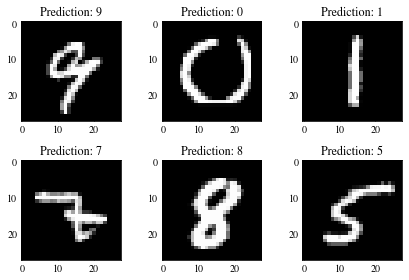

In [6]:
'''Visualize examples of our predictions'''

# pick some examples and their predictions
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = my_cnn(example_data)

# create a new figure
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    # plot the example image
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    # choose the label with the maximum weight as the prediction
    plt.title("Prediction: {}".format(
        output.data.max(dim=1)[1][i].item()))
plt.show()

Figure 3: Some test examples with their predictions generated by the neural network trained above.